# Demonstration of how to use `gizmo.spatial_partitions` using Flint map.

Updated by Aaron Deich on Sept 24, 2021

In [1]:
import seaborn as sns
import numpy as np
import matplotlib as mpl
import pandas as pd

from matplotlib import pyplot as plt
from pathlib import Path

import sys
sys.path.append('../..')

from service_line_pipeline import models
from service_line_pipeline.models import get_models

from importlib import reload

from gizmo import spatial_partitions
from gizmo.spatial_partitions import partitions

## Introduction

`spatial_partitions` is a library I built for BlueConduit in early 2021. It contains a rich feature set for splitting geospatial datasets by spatial tiling. This library was built to support our needs in spatial feature engineering, connected graph smoothing algorithms, and heat map creation for any numerical data type. 

This library includes features in the following areas:

1. Map & graph visualizations
1. Three different tiling types: hexagon, square, and block.
1. Aggregate statistics on across tiles. 
1. Spatial cross-validation splits. 

This notebook contains a tour of how to use this library.

*A note on terminology: in this notebook, we use the words **partition** and **tile**; or **partitions** and **tiling** interchangeably. The definition of a geometric tiling, broadly, is a set of shapes that completely cover a surface and that do not overlap. This library indeed generates tilings for city maps. So why did we call them partitions? When we wrote it, we had 'partitions' in mind, as we had been thinking in the context of breaking  datasets into partitions for use in cross validation.*

## Load Flint data

First, let's load our data.

In [95]:
# from service_line_pipeline.data import get_flint_data #, get_benton_harbor_data, get_toledo_data

# X = get_flint_data() 

# X = X.loc[X['has_lead'].notna(), :].reset_index(drop=True) 
    
# X_flint, y_flint = (
#             X.drop('has_lead', axis="columns"),
#             X['has_lead'].astype(int).to_numpy(),
#         )

from blue_conduit_spatial.utilities import build_datasets, load_datasets

data_dir = '../data'
data_raw_path = f'{data_dir}/raw/flint_sl_materials/'
save_dir = f'{data_dir}/processed'

# Build and save
# Xdata, Ydata, pid, train_idx, test_idx = build_datasets(data_raw_path, save_dir)
Xdata, Ydata, pid, train_idx, test_idx = load_datasets(save_dir)

In [58]:
# gpd.base.GeometryDtype
# pid.geometry.dtype

# gpd.array.GeometryDtype(pid.geometry)
# gpd.GeoDataFrame(pid, crs="EPSG:4326", geometry='geometry')
pid.to_file("sample.gpkg", driver="GPKG")


In [62]:
gpd.read_file('sample.gpkg')

,pid,Latitude,Longitude,geometry
0,4012482018,43.019000,-83.696946,"POLYGON ((13302343.764 554180.147, 13302392.94..."
1,4013226009,43.017650,-83.697217,"POLYGON ((13302416.008 553775.193, 13302382.97..."
2,4012476011,43.020783,-83.697495,"POLYGON ((13302324.175 554929.107, 13302330.78..."
3,4012481022,43.017543,-83.698229,"POLYGON ((13302133.281 553746.175, 13302100.92..."
4,4013226025,43.013583,-83.695357,"POLYGON ((13302290.107 553667.639, 13302290.12..."
...,...,...,...,...
26852,4002378026,43.033874,-83.725367,"POLYGON ((13294918.378 559687.735, 13294865.92..."
26853,4002459029,43.031767,-83.721420,"POLYGON ((13295916.727 558834.791, 13295799.78..."
26854,4002378013,43.033316,-83.723695,"POLYGON ((13295199.728 559408.537, 13295255.14..."
26855,4002459031,43.031433,-83.721612,"POLYGON ((13295750.463 558765.434, 13295767.49..."


In [10]:
# from service_line_pipeline.data import get_data

# get_data('flint')

In [2]:
import geopandas as gpd

X = gpd.read_file('../data/raw/flint_sl_materials/')
X['colors'] = ['#FF0000' if x == '1' else '#0070C0' for x in X.dangerous.values]

<AxesSubplot:>

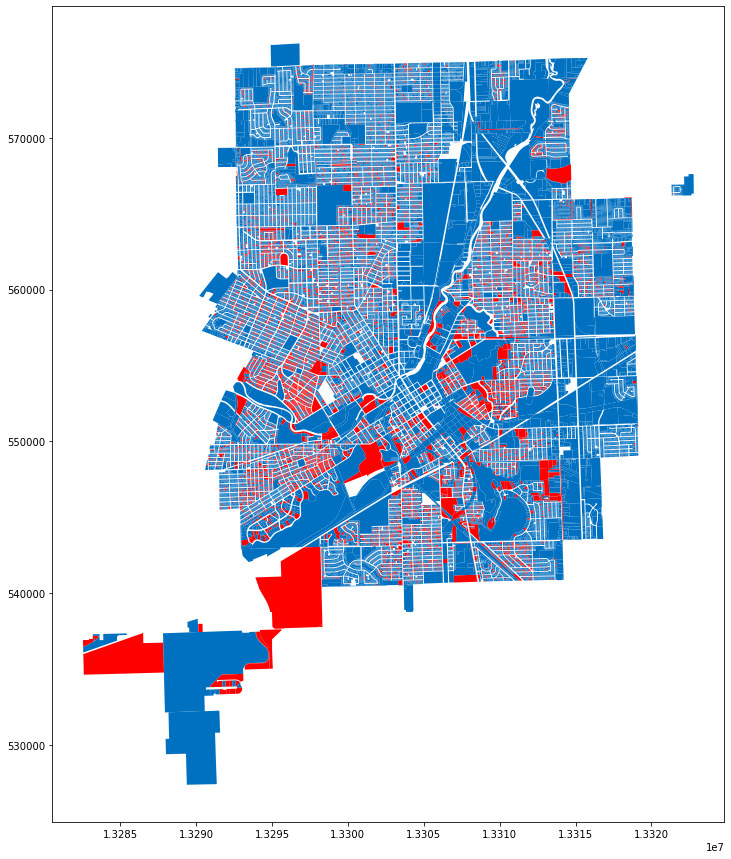

In [3]:
X.plot(figsize = (15,15), color = X['colors'])

## Start by creating a `PartitionsBuilder` for your city's dataset.

We have to first construct a `PartitionsBuilder` object for the Flint data. We will use this object to generate any different custom partition object on top the same data. Note: this `PartitionsBuilder` is *not* a partitions object itself. That step will come next.



In [99]:
pid.pid.values

array([4012482018, 4013226009, 4012476011, ..., 4002378013, 4002459031,
       4011133029])

In [2]:
import geopandas as gpd

X = gpd.read_file('../data/raw/flint_sl_materials/')
X['parcel_id'] = X.pid
X['has_lead'] = X.dangerous
X['year_built'] = X['Year Built']
X['parcel_acres'] = X['Parcel Acr']

partitions_builder = partitions.PartitionsBuilder(
    parcel_gdf=X,
    parcel_id_col='parcel_id',
    target_col='has_lead',
    copy_all_cols=True
)

2021-10-26 11:28.27 [info     ] New PartitionsBuilder created, using 40.22 MB of memory


In [107]:
partitions_builder.parcel_gdf.shape

(55858, 89)

In [108]:
X.shape

(55858, 89)

In [74]:
with open('partitions_builder.pk', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(partitions_builder, outp, pickle.HIGHEST_PROTOCOL)

## Create an individual tiling for Flint. This is called a `Partition` object.

Let's generate a **hexagonal** `Partition` object. There are two other tiling options: **square** and **block** (OpenStreetMap-inferred city blocks)--we will look at these options later in this tutorial.

In [75]:
with open('partitions_builder.pk', 'rb') as f:  # Overwrites any existing file.
    partitions_builder = pickle.load(f)

Let's read the output log from this partitioning creation--we see that the following steps occurred:

1. A new `Partition` object was instantiated. 
1. A hexagonal tiling map was created from scratch, represented by a GeoPandas GeoDataFrame.
1. GeoPandas performed a spatial join between the original parcel data and the hexagonal tiling. This allows the program to figure out which hexagon each parcel falls into, and assigns that hexagon as a foreign key to the original parcel data.
1. A NetworkX connected graph is built on top of the hexagonal tiling. Each node of the graph represents the geographic center of a hexagon. A new edge is created for every pair of hexagons that come into contact. 
1. The `Partition` object is returned. We've named it 'hexagons', but really you can name it anything. Pineapple, for instance.

## Touring a `Partition` object

Let's first visualize this partition and its graph with the built-in plotter:

2021-10-26 11:28.35 [info     ] Generating the partition map of type 'hexagon'


100%|██████████████████████████████████████| 233/233 [00:00<00:00, 21986.88it/s]

2021-10-26 11:28.39 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-26 11:28.39 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:116: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-26 11:28.44 [debug    ] Total parcels after join: 55858
2021-10-26 11:28.45 [info     ] Building the connected graph on the partitions.
2021-10-26 11:28.46 [info     ] New Partition dataframe of type 'hexagon' created, using at least 37.71 MB of memory


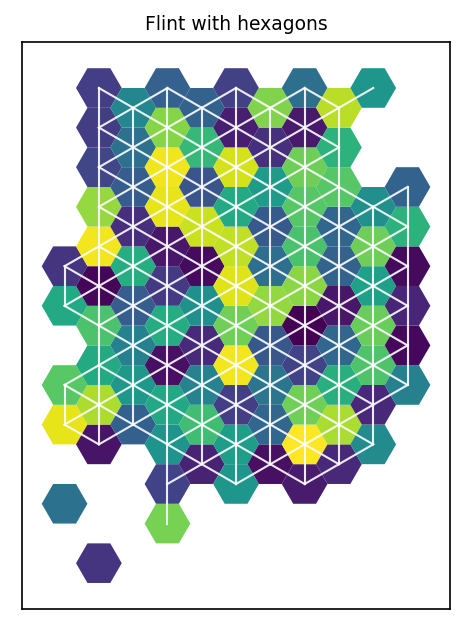

In [3]:
hexagons = partitions_builder.Partition(partition_type='hexagon', num_cells_across=20)
ax = hexagons.plot(figsize=(5, 5), show_graph=True, title='Flint with hexagons')

In [109]:
hexagons.parcel_gdf.pid.shape

(51797,)

In [112]:
# X[X.pid.isin(hexagons.parcel_gdf.pid)==False]
hexagons.parcel_gdf.shape, X.shape

((51797, 90), (55858, 89))

In [113]:
filter_ = X.pid.isin(hexagons.parcel_gdf.pid).values
X_ = X.iloc[filter_,:]
X.shape

(55858, 89)

In [122]:
X.iloc[X.pid.isin(hexagons.parcel_gdf.pid).values,:].shape

(51797, 89)

In [19]:
import pickle

with open('hexagons_sample.pk', 'wb') as outp:  # Overwrites any existing file.
    pickle.dump(hexagons, outp, pickle.HIGHEST_PROTOCOL)

### Useful data structures contained within the `Partition` object.

Here are the three most useful inner data structures you might copy from within this `Partition`:
1. `parcel_gdf`: The inner copy of the original parcel GDF for Flint. Notice this has a new added column,  'partition_ID', on the right side of the dataframe. This is useful for data aggregation.
1. `partition_gdf`: This is the geodataframe representing the partitions themselves. The index here, 'partition_ID' is the same as the column in the parcel_gdf, above.
1. `partitions_graph`: this object contains the NetworkX graph object built atop the city. [NetworkX](https://networkx.org/documentation/stable/tutorial.html) is a rich graph operations library that runs quickly.

Let's inspect those three structures to see what they contain:

In [4]:
print('parcel_gdf:')
display(hexagons.parcel_gdf.head(3))

print('partition_gdf:')
display(hexagons.partition_gdf.head(3))

print('partitions_graph. Contains NetworkX graph:')
display(hexagons.partition_graph.graph.nodes)

parcel_gdf:


,pid,Property Z,Owner Type,Owner Stat,Homestead,Homestea_1,HomeSEV,Land Value,Land Impro,Residentia,...,hv_visit,sl_visit,replaced,dangerous,geometry,parcel_id,has_lead,year_built,parcel_acres,partition_ID
0,4012485002,48502.0,Private,MI,No,0.0,0,830,0,0,...,None,None,None,None,"POLYGON ((13303201.537 554701.620, 13303320.66...",4012485002,None,0,0.045,31
1,4118132003,48503.0,Public,MI,No,0.0,0,0,0,0,...,None,None,None,None,"POLYGON ((13305853.904 553358.315, 13305704.00...",4118132003,None,0,0.000,31
2,4107356001,48503.0,Public,MI,No,0.0,0,0,0,0,...,None,None,None,None,"POLYGON ((13303749.494 554731.588, 13303759.10...",4107356001,None,0,0.000,31


partition_gdf:


,geometry
partition_ID,
0,"POLYGON ((13286711.191 536867.582, 13285369.37..."
1,"POLYGON ((13294762.117 532219.378, 13293420.29..."
2,"POLYGON ((13294762.117 536867.582, 13293420.29..."


partitions_graph. Contains NetworkX graph:


NodeView((0, 1, 2, 3, 4, 11, 5, 12, 6, 13, 7, 14, 8, 15, 9, 16, 10, 17, 18, 20, 21, 22, 23, 24, 25, 26, 27, 19, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66))

## How to compute aggregate data for each tile in a `Partitions` object

Say you would like to compute aggregate statistics for each hexagon over the city. Generated automatically -- if the `target_col` is already set--then `sum`, `count`, and `rate` stats are generated for each tile:

In [5]:
parcel_stats_gdf, partition_stats_gdf = hexagons.compute_partition_stats()

display(parcel_stats_gdf.head(4))
display(partition_stats_gdf.head(2))

ZeroDivisionError: division by zero

**How to interpret the above:** the first dataframe, `parcel_stats_gdf` lists each tile's stats, but copied identically to every original parcel within that tile. Useful for feature engineering for predictive models. The second dataframe, `partition_stats_gdf`, lists each partitions' stats only once, indexed by partition.

Now let's repeat the same process, but also compute numeric statistics on data features, we can include a list of those columns from the original dataset:

In [6]:
parcel_gdf, partition_gdf = hexagons.compute_partition_stats(numeric_feature_cols=['year_built', 'parcel_acres'])

display(parcel_gdf.head(2))
display(partition_gdf.head(2))

ZeroDivisionError: division by zero

These numeric stats automatically include for each feature:

1. mean
1. median
1. min
1. max
1. std
1. quartiles

All of these aggregate statistics features are automatically stored internally to the `Partition` object, and you may then make a heat plot of any of these features by name. For instance, let's make a heatmap of the lead rate for Flint:


BaseException: The column 'has_lead_rate' does not yet exist in the partition_gdf!
                        You might try including the column upon PartitionBuilder creation,
                        using the copy_cols_list or copy_all_cols arguments, or by creating
                        the column after by calling <Partition>.compute_partition_stats().
                    

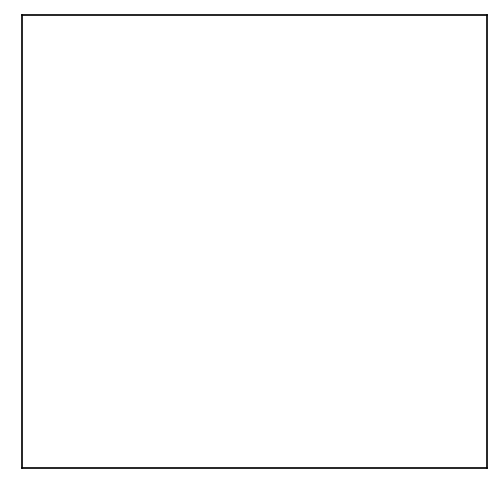

In [7]:
ax = hexagons.plot(figsize=(4, 4), column='has_lead_rate', title='Lead rate for each partition in Flint')

### Other tilings: 'squares' and 'blocks'

We can use the same `PartitionsBuilder` object we created above to create two other types of `Partitions` objects:

1. **squares**: specify num_cells_across
1. **blocks**: download osmnx data: 'query_str' sent to the Openstreetmaps data. This may take a minute or two to generate!
    1. 'cache_graph_dir': optional cacheing directory so as to not re-download the whole osmnx dataset each time.
   

2021-10-25 19:45.15 [info     ] Generating the partition map of type 'square'


100%|████████████████████████████████████████████████████████████████████████| 16/16 [00:00<00:00, 5532.47it/s]

2021-10-25 19:45.17 [info     ] Tesselate() is performing gpd.sjoin() to remove partitions that contain no parcels.
2021-10-25 19:45.17 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()



/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:124: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-25 19:45.21 [debug    ] Total parcels after join: 55858
2021-10-25 19:45.22 [info     ] Building the connected graph on the partitions.
2021-10-25 19:45.22 [info     ] New Partition dataframe of type 'square' created, using at least 37.30 MB of memory
2021-10-25 19:45.24 [info     ] Generating the partition map of type 'block'
2021-10-25 19:45.24 [info     ] Loading cached osmnx graph pickle: data/Flint/osmnx_street_graph.pkl
Building polygons from street data ...
2021-10-25 19:45.25 [debug    ] unary_union operation
2021-10-25 19:45.26 [debug    ] Total block polygons from osmnx: 2587
2021-10-25 19:45.26 [info     ] Building the partition-parcel lookup table with add_partition_ID_via_sjoin()


/Users/Javiera/Desktop/Harvard/MS/Classes/Third Term/AC297r/teamBlueConduit/gizmo/gizmo/spatial_partitions/partitions.py:86: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  **kwargs,


2021-10-25 19:45.31 [debug    ] Total parcels after join: 55858
2021-10-25 19:45.31 [info     ] Building the connected graph on the partitions.
add_contiguous_neighbors stopwatch: Built STRtree after 0.775326s
add_contiguous_neighbors stopwatch: Built STRtree index after 0.003664s
add_contiguous_neighbors stopwatch: Performed STRtree neighbor lookups after 1.691508s
2021-10-25 19:45.36 [debug    ] Removed non-touching neighbors
2021-10-25 19:45.36 [info     ] New Partition dataframe of type 'block' created, using at least 40.66 MB of memory


<AxesSubplot:title={'center':'Blocks for Flint'}>

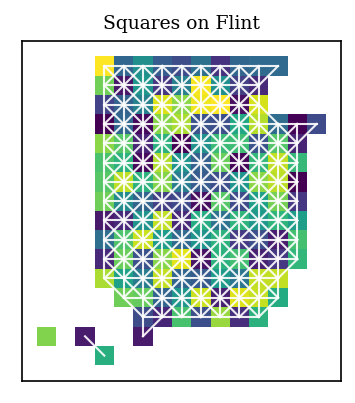

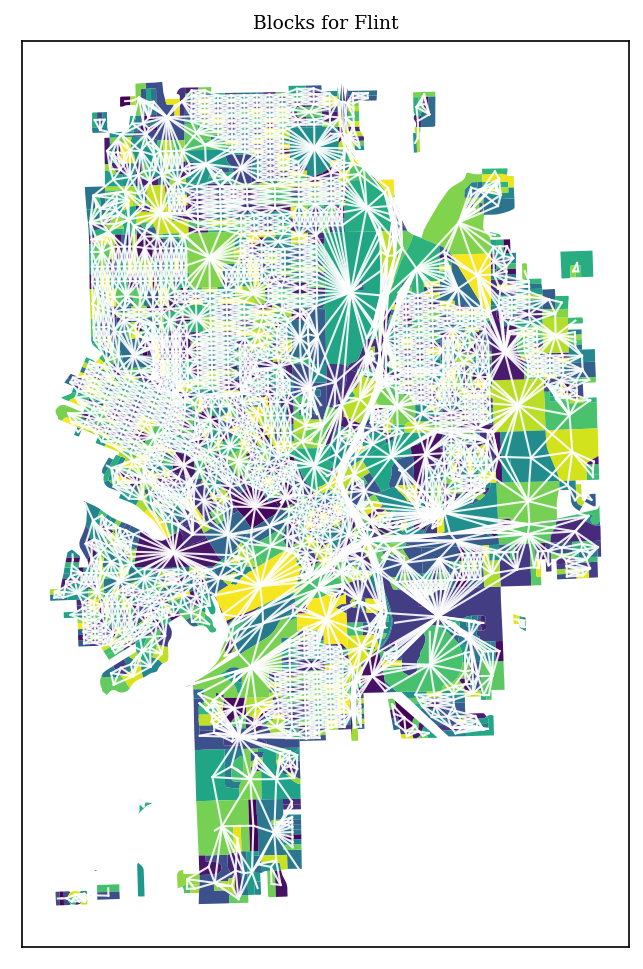

In [8]:
squares = partitions_builder.Partition(partition_type='square', num_cells_across=15)

blocks = partitions_builder.Partition(partition_type='block', query_str='Flint, MI, USA',
                                               cache_graph_dir='data/Flint')

squares.plot(figsize=(3, 3), show_graph=True, title='Squares on Flint')
blocks.plot(figsize=(8, 8), show_graph=True, title='Blocks for Flint')


## Cross-Validation splitting along partitions using `Partition.cv_splitter()`

To aid in spatial cross validation, this returns a `scikit-learn`-like generator object which yields train/test index sets across the partitions. We use this to try to remove spatial overfitting. 

2021-10-25 20:59.11 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-25 20:59.11 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
2021-10-25 20:59.11 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'
train: (37785,) test: (14012,)
train: (37034,) test: (14763,)
train: (39438,) test: (12359,)


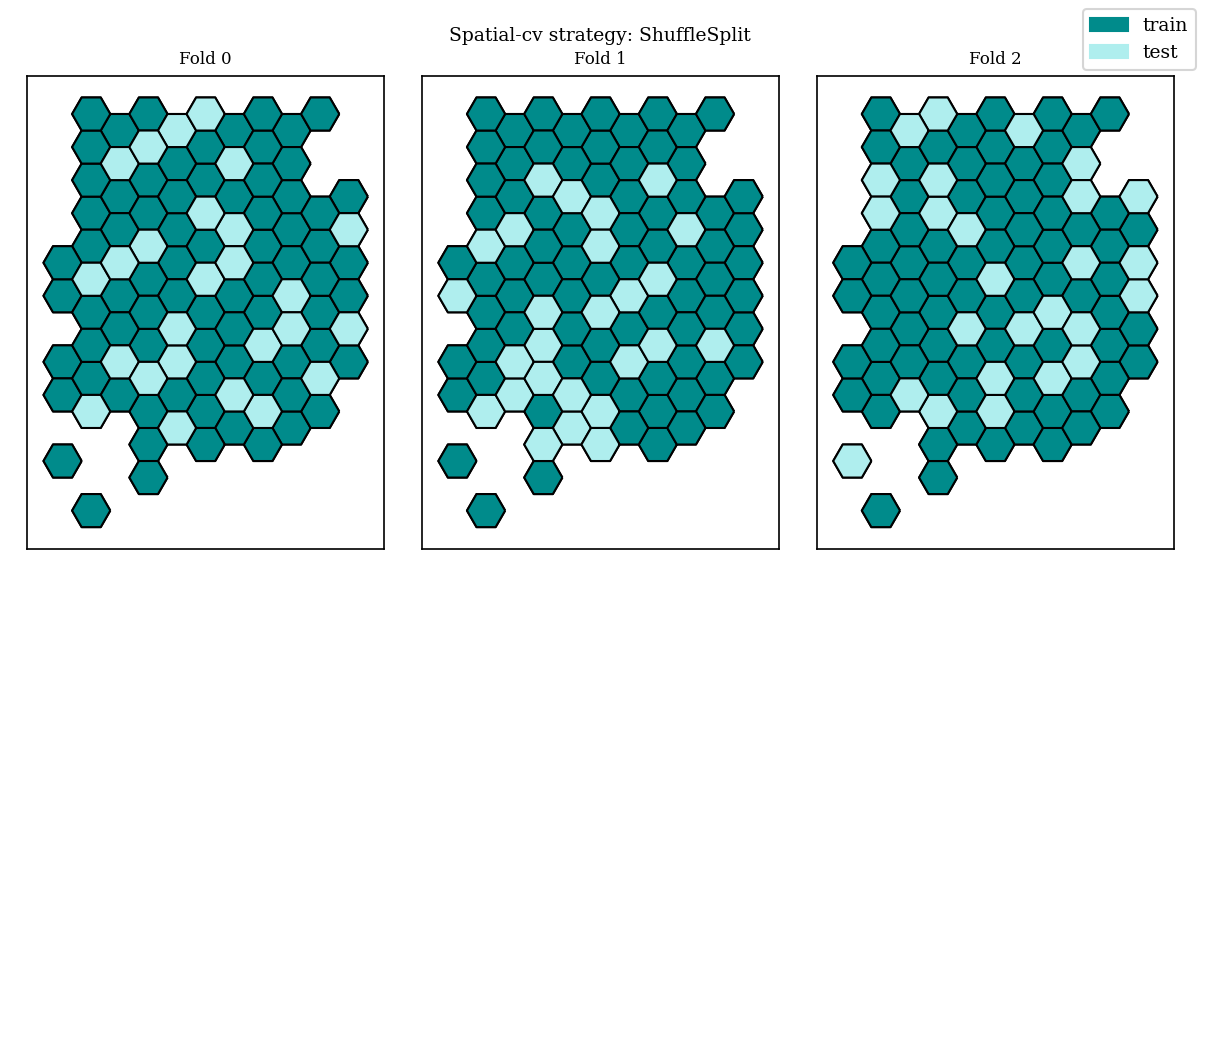

In [102]:
hex_splitter = hexagons.cv_splitter(n_splits=3, strategy='ShuffleSplit', plot=True, random_state=5)

# Here is how to use the splitter for cross validation. These train_parcels, test_parcels
# are lists of parcel indices.
for train_parcels, test_parcels in hex_splitter.split(output_level='parcel'):
    print("train: " + str(train_parcels.shape), 'test: ' + str(test_parcels.shape))

In [124]:
train_idx, test_idx = list(zip(*hex_splitter.split(output_level='parcel')))

2021-10-25 23:06.16 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'


In [131]:
np.array(train_idx, dtype=object)

array([Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   51787, 51788, 51789, 51790, 51791, 51792, 51793, 51794, 51795,
                   51796],
                  dtype='int64', length=37785)                                   ,
       Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   51787, 51788, 51789, 51790, 51791, 51792, 51793, 51794, 51795,
                   51796],
                  dtype='int64', length=37034)                                   ,
       Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                       9,
                   ...
                   51784, 51785, 51786, 51787, 51788, 51789, 51790, 51791, 51792,
                   51793],
                  dtype='int64', length=39438)                                   ],
      dtype=object)

2021-10-26 11:31.00 [info     ] Made Partition.cv_splitter instance with n_splits=3; strategy=ShuffleSplit
2021-10-26 11:31.01 [info     ] SpatialSplitter.split() is running with strategy 'ShuffleSplit'


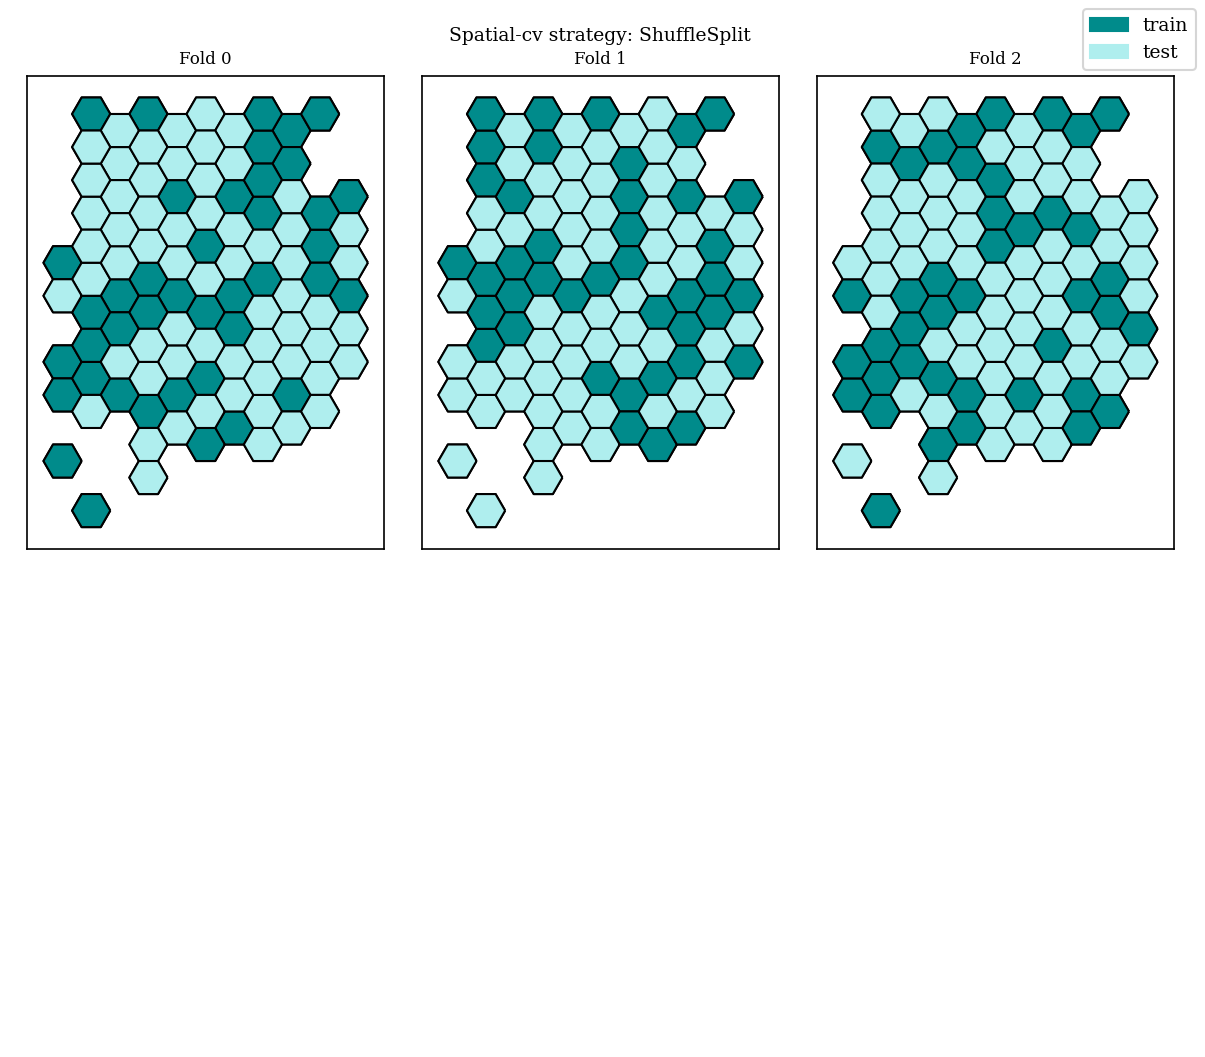

In [6]:
# hexagons.cv_splitter(n_splits=3, strategy='ShuffleSplit', plot=True, random_state=5)
hexagons.cv_splitter(n_splits=3, strategy='ShuffleSplit', plot=True, random_state=5, test_size=0.6)